## Import Library & files

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [51]:
from dataclasses import dataclass
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random as rd
from dtaidistance import dtw
from dtaidistance.clustering import KMedoids
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.agglomerative import agglomerative, type_link
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [3]:
from tools import generate_k_factor_data, generate_true_lag_data
from tools import ClusteringArgs
from tools import DistArgs
from tools import compute_clusters_from_dist_matrix

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## General Parameters & Functions

In [5]:
N_POINTS = 100
MAX_LAG = 5
N_ASSETS = 120

In [6]:
def init_itter_centers(
    K: int, n_assets: int, dist_method_range: list, arr_rets: np.array
) -> list:
    if dist_method_range == "kmeans":
        initial_centers = kmeans_plusplus_initializer(arr_rets, K).initialize()
        return [kmeans, initial_centers]
    else:
        initial_medoids = np.random.randint(0, n_assets, K)
        return [kmedoids, initial_medoids]

In [7]:
def create_df_helper(val: list, std_range: list) -> pd.DataFrame:
    df = pl.DataFrame(val)
    cols = df.columns
    df = (
        df.with_columns(
            [pl.col(c).mean().alias("mean_" + c) for c in cols]
            + [
                (pl.col(c).mean() + pl.col(c).std()).alias("upper_ci_" + c)
                for c in cols
            ]
            + [
                (pl.col(c).mean() - pl.col(c).std()).alias("lower_ci_" + c)
                for c in cols
            ]
        )
        .select(["^mean.*$", "^upper.*$", "^lower.*$"])
        .unique()
    )

    return pd.DataFrame(
        {
            "std": std_range,
            "mean": df.select(["^mean.*$"]).transpose().to_series().to_list(),
            "upper_ci": df.select(["^upper.*$"])
            .transpose()
            .to_series()
            .to_list(),
            "lower_ci": df.select(["^lower.*$"])
            .transpose()
            .to_series()
            .to_list(),
        }
    ).set_index("std")


def create_df_res(ari_per_dist: dict[dict], std_range: list):
    out = {}
    for idx, values in ari_per_dist.items():
        out[idx] = create_df_helper(val=values, std_range=std_range)
    return out

# Clustering Study

## DTW VS Other distance metrics

#### Parameters

In [8]:
STD_MAX = 3.0
STD_STEP = 0.5
STD_RANGE = np.arange(start=0, stop=STD_MAX + STD_STEP, step=STD_STEP)
COLS = [str(std) for std in STD_RANGE]
DISTANCE_METHOD_RANGE = [
    ("kmeans", {}),
    ("euclidean", {}),
    ("cityblock", {}),
    ("cosine", {}),
    ("dtw", {"window": 6}),
]
N_ITTER = 50
K_MIN = 2
K_MAX = 5
K_RANGE = [i for i in range(K_MIN, K_MAX)]

#### ARI measure computation

In [9]:
res_per_factor = []
for k in K_RANGE:
    ari_per_dist_1 = {
        dist[0]: {str(std): [] for std in STD_RANGE}
        for dist in DISTANCE_METHOD_RANGE
    }
    for _ in tqdm(range(N_ITTER)):
        for std in STD_RANGE:
            arr_data = generate_k_factor_data(
                n_points=N_POINTS,
                std=std,
                max_lag=MAX_LAG,
                n_assets=N_ASSETS,
                k_factor=k,
            )

            for dist in DISTANCE_METHOD_RANGE:
                cluster_recipe = init_itter_centers(
                    K=k,
                    arr_rets=arr_data["rets"],
                    n_assets=N_ASSETS,
                    dist_method_range=dist[0],
                )

                dist_args = DistArgs(method=dist[0], args=dist[1])

                pred_clusters = compute_clusters_from_dist_matrix(
                    arr_rets=arr_data["rets"],
                    dist_args=dist_args,
                    cluster_recipe=cluster_recipe,
                )

                ari_per_dist_1[dist[0]][str(std)].append(
                    adjusted_rand_score(arr_data["cluster"], pred_clusters)
                )

    res_per_factor.append(
        create_df_res(ari_per_dist=ari_per_dist_1, std_range=STD_RANGE)
    )

100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


#### Analyse Results

In [10]:
def plot_ari_per_factor_model(ax, res_ari: list, colors: list, K: int):
    ax = set_layer(ax)
    for elem, c in zip(res_ari.items(), colors):
        vals = elem[1]
        vals["mean"].plot(ax=ax, color=c, marker=".", label=elem[0])
        idx = vals.index
        ax.fill_between(idx, vals["mean"], vals["upper_ci"], alpha=0.2, color=c)
        ax.fill_between(idx, vals["mean"], vals["lower_ci"], alpha=0.2, color=c)
    ax = set_layer(ax)
    ax.set_title(str(K) + " Factors Model", size=15)
    ax.set_xlabel("Standard Deviation", size=13)
    ax.set_ylabel("ARI", size=13)
    plt.legend()


def set_layer(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # ax.grid(axis="x", color="#A8BAC4", lw=0.5, alpha=0.3)
    ax.grid(axis="y", color="#A8BAC4", lw=0.3, alpha=0.5)
    return ax

In [11]:
COLORS = ["darkviolet", "darkred", "cyan", "darkblue", "lime"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


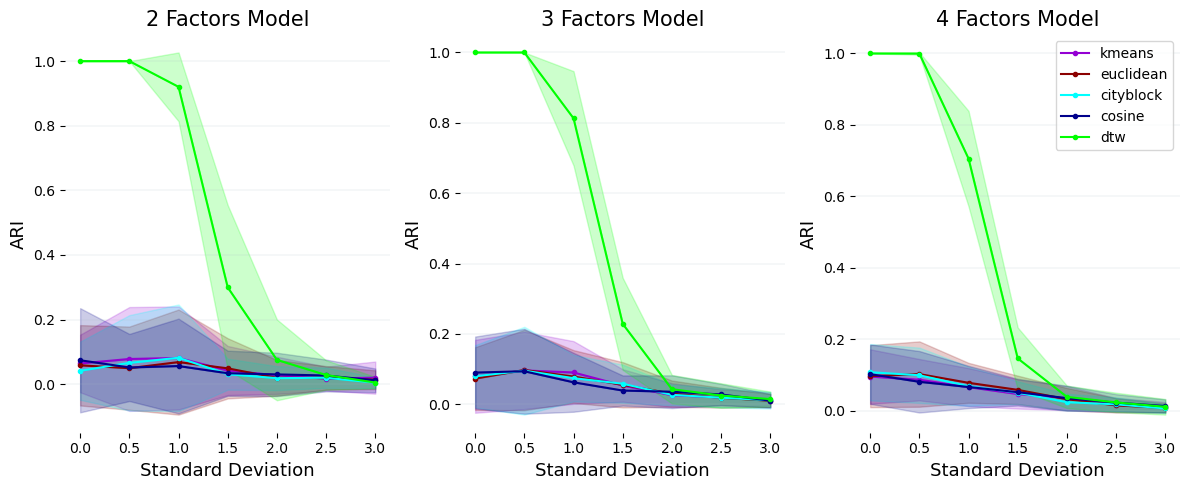

In [12]:
fig, axes = plt.subplots(1, len(K_RANGE), figsize=(12, 5))
for i in range(len(K_RANGE)):
    plot_ari_per_factor_model(
        ax=axes[i], res_ari=res_per_factor[i], colors=COLORS, K=K_RANGE[i]
    )
plt.tight_layout()

## Kmedoids vs Agglomerative clustering

In [48]:
def gen_labels_from_pyclustering(
    clusters: list[list], n_elem: int
) -> list[int]:
    res = np.zeros(n_elem)
    for idx, val in enumerate(clusters):
        np.put(a=res, ind=list(val), v=idx)
    return res


def create_df_res(ari_per_dist: dict[dict], std_range: list):
    out = {}
    for idx, values in ari_per_dist.items():
        out[idx] = create_df_helper(val=values, std_range=std_range)
    return out


def create_df_helper(val: list, std_range: list) -> pd.DataFrame:
    df = pl.DataFrame(val)
    cols = df.columns
    df = (
        df.with_columns(
            [pl.col(c).mean().alias("mean_" + c) for c in cols]
            + [
                (pl.col(c).mean() + pl.col(c).std()).alias("upper_ci_" + c)
                for c in cols
            ]
            + [
                (pl.col(c).mean() - pl.col(c).std()).alias("lower_ci_" + c)
                for c in cols
            ]
        )
        .select(["^mean.*$", "^upper.*$", "^lower.*$"])
        .unique()
    )

    return pd.DataFrame(
        {
            "std": std_range,
            "mean": df.select(["^mean.*$"]).transpose().to_series().to_list(),
            "upper_ci": df.select(["^upper.*$"])
            .transpose()
            .to_series()
            .to_list(),
            "lower_ci": df.select(["^lower.*$"])
            .transpose()
            .to_series()
            .to_list(),
        }
    ).set_index("std")

In [70]:
STD_MAX = 3.0
STD_STEP = 0.5
STD_RANGE = np.arange(start=0, stop=STD_MAX + STD_STEP, step=STD_STEP)
COLS = [str(std) for std in STD_RANGE]
CLUSTER_METHODS = {
    "kmedoids": [kmedoids],
    "agglo_average": [agglomerative, type_link.AVERAGE_LINK],
    "agglo_centroids": [agglomerative, type_link.CENTROID_LINK],
    "agglo_complete": [agglomerative, type_link.COMPLETE_LINK],
}
N_ITTER = 50
K_MIN = 2
K_MAX = 4
K_RANGE = [i for i in range(K_MIN, K_MAX)]

In [71]:
res_per_factor_per_cluster = []
for k in K_RANGE:
    ari_per_cluster_method = {
        name: {str(std): [] for std in STD_RANGE}
        for name, cluster_recipe in CLUSTER_METHODS.items()
    }
    for _ in tqdm(range(N_ITTER)):
        for std in STD_RANGE:
            arr_data = generate_k_factor_data(
                n_points=N_POINTS,
                std=std,
                max_lag=MAX_LAG,
                n_assets=N_ASSETS,
                k_factor=k,
            )

            for name, cluster_recipe in CLUSTER_METHODS.items():
                dist_matrix = dtw.distance_matrix_fast(
                    arr_data["rets"], window=5 + 1
                )

                if name == "kmedoids":
                    clust_obj = cluster_recipe[0](
                        dist_matrix, np.random.randint(0, N_ASSETS, k)
                    )
                else:
                    clust_obj = cluster_recipe[0](
                        dist_matrix, k, cluster_recipe[1]
                    )

                clust_obj.process()
                pred_clusters = gen_labels_from_pyclustering(
                    clusters=clust_obj.get_clusters(), n_elem=N_ASSETS
                )

                ari_per_cluster_method[name][str(std)].append(
                    adjusted_rand_score(arr_data["cluster"], pred_clusters)
                )

    res_per_factor_per_cluster.append(
        create_df_res(ari_per_dist=ari_per_cluster_method, std_range=STD_RANGE)
    )

100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


In [72]:
res_per_factor_per_cluster

[{'kmedoids':          mean  upper_ci  lower_ci
  std                              
  0.0  1.000000  1.000000  1.000000
  0.5  1.000000  1.000000  1.000000
  1.0  0.770556  1.000422  0.540690
  1.5  0.253264  0.509986 -0.003458
  2.0  0.106887  0.319586 -0.105812
  2.5  0.030493  0.116980 -0.055995
  3.0  0.040791  0.145694 -0.064111,
  'agglo_single':          mean  upper_ci  lower_ci
  std                              
  0.0  1.000000  1.000000  1.000000
  0.5  1.000000  1.000000  1.000000
  1.0  0.001474  0.008306 -0.005358
  1.5  0.000000  0.000000  0.000000
  2.0  0.000294  0.002371 -0.001783
  2.5  0.000048  0.002785 -0.002690
  3.0 -0.000195  0.001790 -0.002180,
  'agglo_average':          mean  upper_ci  lower_ci
  std                              
  0.0  1.000000  1.000000  1.000000
  0.5  1.000000  1.000000  1.000000
  1.0  0.560044  0.878410  0.241678
  1.5  0.132639  0.341998 -0.076721
  2.0  0.066656  0.234070 -0.100759
  2.5  0.003083  0.065238 -0.059072
  3.0  0.019606  

## Effect of DTW "Window" parameters

#### Parameters & Function

In [13]:
STD = 1.0
TRUE_LAG = 4

COLS = [str(std) for std in STD_RANGE]

WINDOW_PARAMS_RANGE = [i for i in range(0, 10)]
DISTANCE_METHOD_RANGE = [
    ("dtw", {"window": w, "onlytriu": True}) for w in WINDOW_PARAMS_RANGE
]

N_ITTER = 100
K_MIN = 2
K_MAX = 5
K_RANGE = [i for i in range(K_MIN, K_MAX)]

In [14]:
def gen_labels(clusters: dict, n_elem: int) -> list[int]:
    res = np.zeros(n_elem)
    for idx, val in clusters.items():
        np.put(a=res, ind=list(val), v=idx)
    return res

In [15]:
def create_df_res_per_window(ari_per_dist: dict, window_range: list):
    df = pl.DataFrame(ari_per_dist)
    cols = df.columns
    df = (
        df.with_columns(
            [pl.col(c).mean().alias("mean_" + c) for c in cols]
            + [
                (pl.col(c).mean() + pl.col(c).std()).alias("upper_ci_" + c)
                for c in cols
            ]
            + [
                (pl.col(c).mean() - pl.col(c).std()).alias("lower_ci_" + c)
                for c in cols
            ]
        )
        .select(["^mean.*$", "^upper.*$", "^lower.*$"])
        .unique()
    )

    return pd.DataFrame(
        {
            "std": window_range,
            "mean": df.select(["^mean.*$"]).transpose().to_series().to_list(),
            "upper_ci": df.select(["^upper.*$"])
            .transpose()
            .to_series()
            .to_list(),
            "lower_ci": df.select(["^lower.*$"])
            .transpose()
            .to_series()
            .to_list(),
        }
    ).set_index("std")

#### Compute ARI per windows paramters

In [16]:
res_per_factor_window = []
for k in K_RANGE:
    out_ari_per_dist = {
        "dtw_" + str(i): [] for i in range(len(WINDOW_PARAMS_RANGE))
    }
    for i in tqdm(range(N_ITTER)):
        arr_data = generate_true_lag_data(
            n_points=N_POINTS,
            std=STD,
            max_lag=TRUE_LAG,
            n_assets=N_ASSETS,
            k_factor=k,
        )

        initial_medoids = np.random.randint(0, N_ASSETS, k)
        kmed_cluster_recipe = [kmedoids, initial_medoids]
        for w in WINDOW_PARAMS_RANGE:
            clusters_obj = KMedoids(
                dtw.distance_matrix_fast, {"window": w + 1}, k=k
            )
            clusters_obj.fit(arr_data["rets"])
            clust = gen_labels(clusters_obj.cluster_idx, n_elem=N_ASSETS)

            out_ari_per_dist["dtw_" + str(w)].append(
                adjusted_rand_score(arr_data["cluster"], clust)
            )
    res_per_factor_window.append(
        create_df_res_per_window(
            ari_per_dist=out_ari_per_dist, window_range=WINDOW_PARAMS_RANGE
        )
    )

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


#### Analyse results

In [17]:
def plot_ari_per_window(ax, res_ari_per_window: list, colors: list, K: int):
    ax = set_layer(ax)
    color = "red"
    res_ari_per_window["mean"].plot(
        ax=ax, color=color, marker=".", label="DTW + Kmédoïds"
    )
    idx = res_ari_per_window.index
    ax.fill_between(
        idx,
        res_ari_per_window["mean"],
        res_ari_per_window["upper_ci"],
        alpha=0.2,
        color=color,
    )
    ax.fill_between(
        idx,
        res_ari_per_window["mean"],
        res_ari_per_window["lower_ci"],
        alpha=0.2,
        color=color,
    )
    ax = set_layer(ax)
    ax.set_title(str(K) + " Factors Model", size=15)
    ax.set_xlabel("Window params", size=13)
    ax.set_ylabel("ARI", size=13)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


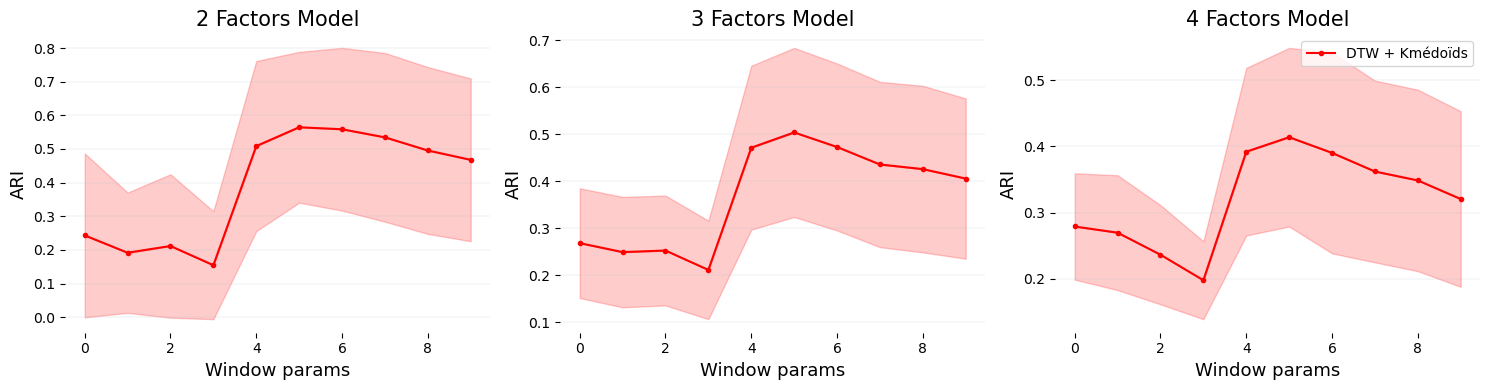

In [18]:
fig, axes = plt.subplots(1, len(K_RANGE), figsize=(15, 4))
for i in range(len(K_RANGE)):
    plot_ari_per_window(
        ax=axes[i],
        res_ari_per_window=res_per_factor_window[i],
        colors=COLORS,
        K=K_RANGE[i],
    )
plt.tight_layout()

# MSE Study

## Compute MSE per std

#### Function & Parameters

In [19]:
def compute_relative_lag(delta_warping_path: np.array, lag_method: str) -> int:
    if lag_method == "median":
        return np.median(delta_warping_path)
    elif lag_method == "mode":
        unique_lag, counts = np.unique(delta_warping_path, return_counts=True)
        return unique_lag[counts.argmax()]
    else:
        print("Lag method parameter should be in ['median', 'mode']")


def compute_lead_lag_value(
    arr_rets_1: np.array, arr_rets_2: np.array, lag_method: str, window: int
) -> int:
    warping_path = dtw.best_path(
        dtw.warping_paths_fast(s1=arr_rets_1, s2=arr_rets_2, window=window)[1]
    )
    delta_warping_path = np.array([p[0] - p[1] for p in warping_path])
    return compute_relative_lag(
        delta_warping_path=delta_warping_path, lag_method=lag_method
    )


def compute_pred_lead_lag_matrix(
    cluster_label: np.array, arr_rets: np.array, lag_method: str, window: int
) -> np.matrix:
    n_asset = len(cluster_label)
    lead_lag_matrix = np.zeros((n_asset, n_asset))
    for i in range(n_asset):
        for j in range(i + 1, n_asset):
            if cluster_label[i] == cluster_label[j]:
                lead_lag_value = compute_lead_lag_value(
                    arr_rets_1=arr_rets[i],
                    arr_rets_2=arr_rets[j],
                    lag_method=lag_method,
                    window=window,
                )
                lead_lag_matrix[i][j] = -lead_lag_value
                lead_lag_matrix[j][i] = lead_lag_value
    return lead_lag_matrix

In [20]:
def compute_pred_clusters(
    rets: np.array,
    nb_facotr: int,
    n_assets: int,
    dist_method: str,
):
    cluster_recipe = init_itter_centers(
        K=nb_facotr,
        arr_rets=rets,
        n_assets=n_assets,
        dist_method_range=dist_method[0],
    )

    dist_args = DistArgs(method=dist_method[0], args=dist_method[1])

    return compute_clusters_from_dist_matrix(
        arr_rets=rets,
        dist_args=dist_args,
        cluster_recipe=cluster_recipe,
    )

In [21]:
def compute_mse(true_lead_lag: np.matrix, pred_lead_lag: np.matrix) -> float:
    return np.mean(np.square(pred_lead_lag - true_lead_lag))

In [22]:
N_ASSETS = 60
N_POINTS = 50

In [23]:
STD_MAX = 3.0
STD_STEP = 0.5
STD_RANGE = np.arange(start=0, stop=STD_MAX + STD_STEP, step=STD_STEP)
COLS = [str(std) for std in STD_RANGE]
DIST_METHOD_MSE = ("dtw", {"window": 6})
LAG_METHOD_RANGE = ["median", "mode"]
N_ITTER = 25
K_MIN = 1
K_MAX = 4
K_RANGE = [i for i in range(K_MIN, K_MAX)]

#### Compute data

In [24]:
res_per_factor_mse = []
for k in K_RANGE:
    mse_per_lag_method = {
        lag_method: {str(std): [] for std in STD_RANGE}
        for lag_method in LAG_METHOD_RANGE
    }
    for itter in tqdm(range(N_ITTER)):
        for std in STD_RANGE:
            arr_data = generate_k_factor_data(
                n_points=N_POINTS,
                std=std,
                max_lag=MAX_LAG,
                n_assets=N_ASSETS,
                k_factor=k,
            )

            pred_clusters = compute_pred_clusters(
                rets=arr_data["rets"],
                nb_facotr=k,
                n_assets=N_ASSETS,
                dist_method=DIST_METHOD_MSE,
            )

            for lag_method in LAG_METHOD_RANGE:
                pred_lead_lag_matrix = compute_pred_lead_lag_matrix(
                    cluster_label=pred_clusters,
                    arr_rets=arr_data["rets"],
                    lag_method=lag_method,
                    window=DIST_METHOD_MSE[1]["window"],
                )

                mse_per_lag_method[lag_method][str(std)].append(
                    compute_mse(
                        true_lead_lag=arr_data["lead_lag_matrix"],
                        pred_lead_lag=pred_lead_lag_matrix,
                    )
                )

    res_per_factor_mse.append(
        create_df_res(ari_per_dist=mse_per_lag_method, std_range=STD_RANGE)
    )

100%|██████████| 25/25 [01:44<00:00,  4.19s/it]


#### Analyse results

In [25]:
def plot_mse_per_factor_model(ax, res_mse: list, colors: list, K: int):
    ax = set_layer(ax)
    for elem, c in zip(res_mse.items(), colors):
        vals = elem[1]
        vals["mean"].plot(ax=ax, color=c, marker=".", label=elem[0])
        idx = vals.index
        ax.fill_between(idx, vals["mean"], vals["upper_ci"], alpha=0.2, color=c)
        ax.fill_between(idx, vals["mean"], vals["lower_ci"], alpha=0.2, color=c)
    ax = set_layer(ax)
    ax.set_title(str(K) + " Factors Model", size=15)
    ax.set_xlabel("Standard Deviation", size=13)
    ax.set_ylabel("MSE", size=13)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


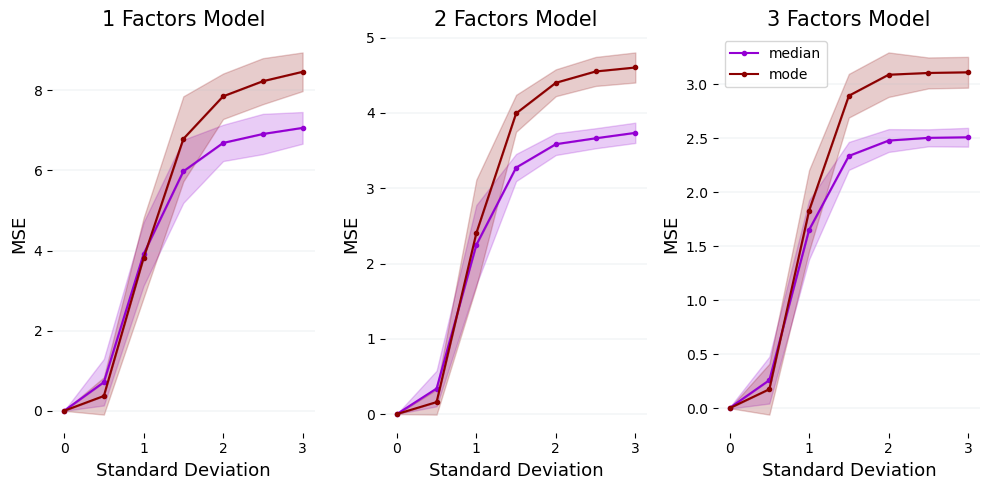

In [26]:
fig, axes = plt.subplots(1, len(K_RANGE), figsize=(10, 5))
for i in range(len(K_RANGE)):
    plot_mse_per_factor_model(
        ax=axes[i], res_mse=res_per_factor_mse[i], colors=COLORS, K=K_RANGE[i]
    )
plt.tight_layout()

## MSE per Window

### Function & Parameters

In [27]:
N_ASSETS = 24
N_POINTS = 100

In [28]:
STD = 1.0
TRUE_LAG = 5

COLS = [str(std) for std in STD_RANGE]

WINDOW_PARAMS_RANGE = [i for i in range(0, 10)]
LAG_METHOD_RANGE = ["median", "mode"]

N_ITTER = 25
K_MIN = 1
K_MAX = 4
K_RANGE = [i for i in range(K_MIN, K_MAX)]

#### Compute data

In [29]:
def create_df_res_per_window(ari_per_dist: dict, window_range: list):
    df = pl.DataFrame(ari_per_dist)
    cols = df.columns
    df = (
        df.with_columns(
            [pl.col(c).mean().alias("mean_" + c) for c in cols]
            + [
                (pl.col(c).mean() + pl.col(c).std()).alias("upper_ci_" + c)
                for c in cols
            ]
            + [
                (pl.col(c).mean() - pl.col(c).std()).alias("lower_ci_" + c)
                for c in cols
            ]
        )
        .select(["^mean.*$", "^upper.*$", "^lower.*$"])
        .unique()
    )

    return pd.DataFrame(
        {
            "window": window_range,
            "mean": df.select(["^mean.*$"]).transpose().to_series().to_list(),
            "upper_ci": df.select(["^upper.*$"])
            .transpose()
            .to_series()
            .to_list(),
            "lower_ci": df.select(["^lower.*$"])
            .transpose()
            .to_series()
            .to_list(),
        }
    ).set_index("std")

In [30]:
res_per_factor_per_window_mse = []
for k in K_RANGE:
    mse_per_lag_method = {
        lag_method: {str(w): [] for w in WINDOW_PARAMS_RANGE}
        for lag_method in LAG_METHOD_RANGE
    }
    for i in tqdm(range(N_ITTER)):
        arr_data = generate_true_lag_data(
            n_points=N_POINTS,
            std=STD,
            max_lag=TRUE_LAG,
            n_assets=N_ASSETS,
            k_factor=k,
        )

        for w in WINDOW_PARAMS_RANGE:
            clusters_obj = KMedoids(
                dtw.distance_matrix_fast, {"window": w + 1}, k=k
            )
            clusters_obj.fit(arr_data["rets"])
            pred_cluster = gen_labels(clusters_obj.cluster_idx, n_elem=N_ASSETS)

            for lag_method in LAG_METHOD_RANGE:
                pred_lead_lag_matrix = compute_pred_lead_lag_matrix(
                    cluster_label=pred_cluster,
                    arr_rets=arr_data["rets"],
                    lag_method=lag_method,
                    window=w + 1,
                )
                mse = compute_mse(
                    true_lead_lag=arr_data["lead_lag_matrix"],
                    pred_lead_lag=pred_lead_lag_matrix,
                )
                mse_per_lag_method[lag_method][str(w)].append(mse)

        # print(mse_per_lag_method)
    res_per_factor_per_window_mse.append(
        create_df_res(
            ari_per_dist=mse_per_lag_method, std_range=WINDOW_PARAMS_RANGE
        )
    )

100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


#### Analyse results

In [31]:
def plot_mse_per_factor_model_per_window(
    ax, res_mse: list, colors: list, K: int
):
    ax = set_layer(ax)
    for elem, c in zip(res_mse.items(), colors):
        vals = elem[1]
        vals["mean"].plot(ax=ax, color=c, marker=".", label=elem[0])
        idx = vals.index
        ax.fill_between(idx, vals["mean"], vals["upper_ci"], alpha=0.2, color=c)
        ax.fill_between(idx, vals["mean"], vals["lower_ci"], alpha=0.2, color=c)
    ax = set_layer(ax)
    ax.set_title(str(K) + " Factors Model", size=15)
    ax.set_xlabel("Window", size=13)
    ax.set_ylabel("MSE", size=13)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


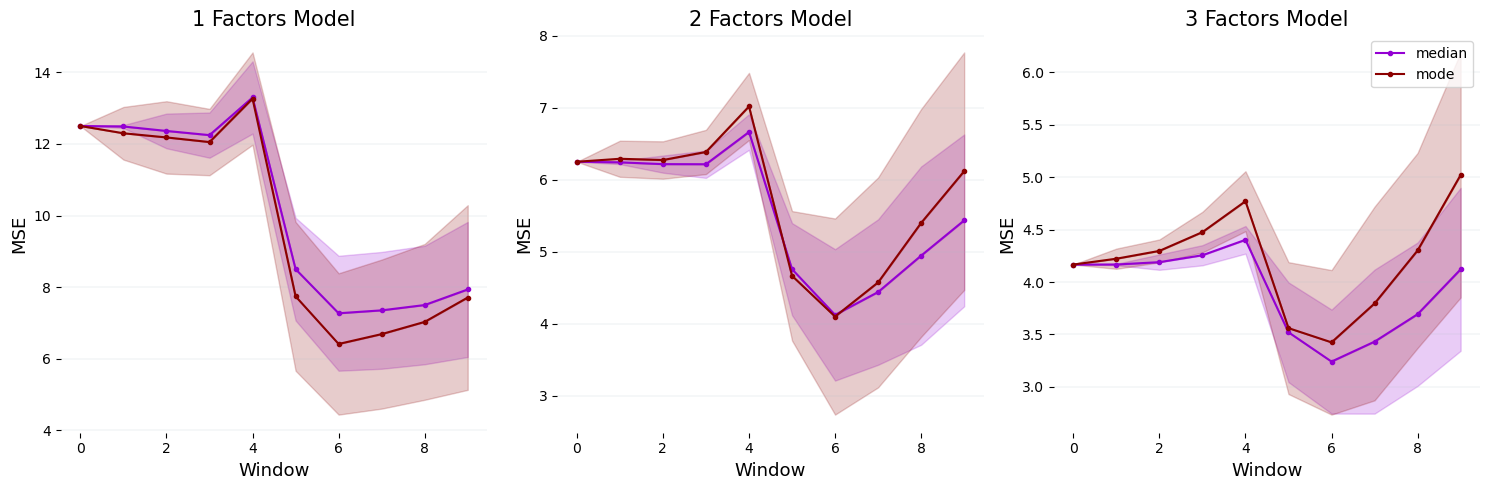

In [32]:
fig, axes = plt.subplots(1, len(K_RANGE), figsize=(15, 5))
for i in range(len(K_RANGE)):
    plot_mse_per_factor_model_per_window(
        ax=axes[i],
        res_mse=res_per_factor_per_window_mse[i],
        colors=COLORS,
        K=K_RANGE[i],
    )
plt.tight_layout()